# Neural Network

**Intention is to train the variables on the Neural Network with several hidden layers and see if a much higher r$^2$ value can be obtained than using the Lasso method. If so then this will imply nonlinearities and interdependence between the variables should be looked at**

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import scipy.signal as sig
from sklearn import neural_network
import datetime
import warnings
import dask

In [91]:
#for running on Casper
from dask_jobqueue import PBSCluster
from dask.distributed import Client

cluster = PBSCluster(cores    = 1,
                     memory   = '1GB',
                     queue    = 'casper',
                     walltime = '01:05:00')

cluster.scale(12)
client = Client(cluster)
client

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42118 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://10.12.206.48:42137 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/cwpowell/proxy/42118/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Load useful data

In [2]:
CMIP6_info = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/raw_data/CMIP6_info/'\
    +'CMIP6_modeling_center_members_doi.nc'
)

#split train:~75%, test:~15%, validation:~10% (not used in this analysis)
mem_split = {'CanESM5':[47,55,64], 'MIROC6':[36,43,49], 
             'GISS-E2-1-G':[31,37,42], 'IPSL-CM6A-LR':[23,27,31],
             'CNRM-CM6-1':[16,19,20], 'NorCPM1':[21,25,29],
             'GISS-E2-1-H':[18,21,22], 'EC-Earth3':[15,18,19]
            }

## Define training function

In [87]:
def train_model_month(sea_ice_data, variability_data, month_, year_lags, 
                      train_test, start_end_yr, hl_sizes, lr_init, max_iteration,
                      tolorence, alphas_list):
    
    '''
    Function which trains and tests a neural network from a single GCM or 
    collection of model data for a single month of sea ice data and with all 
    CVDP climate variables lagged as specified
        
    Input:
        sea_ice_data: xarray dataarray  
            Lowpass filtered standardized sea ice data e.g. SIC or SIT from
            a given model
        variability_data: xarray dataarray
            Climate variable data for all members from a given model
        month_: int
            The month of the year, e.g. 1 for January
        year_lags: list of ints
            List of number of years lagged over which to run the Lasso model
        train_test: list of ints
            List of the member elements up to element x (inclusive) for the 
            training data, and from y to z (inclusive) for the testing data, 
            e.g. [74,90,99] for a 100 member ensemble
        start_end_yr: list of ints
            List of the starting and ending years of analysis e.g. [1950,2014]
            Note that the starting year is that of the sea ice data which does
            not change with lag, CVDP data for a 10 year lag would use 1940 to
            2004 data
        max_iteration: int
            The maximum number of iterations for to fit the data for the 
            Lasso method
        tolorence: float
            The tolorence of the Lasso iterations
        model_sel: str
            The type of Lasso model to use e.g. 'cyclic' or 'random'
        alphas_list: list of floats
            The values of alpha used in the Lasso model e.g. [1.0,1.5,2.0]
        
    Returns:
        tuple of two xarray dataarrays, containing Lasso multiple regression 
        coefficients and scores
    '''
    
    ##################### reorganize sea ice and CVDP data #####################
    #prepare sea ice data for analysis by creating year and month dimensions
    #out of the time dimension - uncomment if using time dim not year,month

    target_data = sea_ice_data.copy()

    #prepare CVDP data for analysis by creating year and month dimensions
    #out of the time dimension
    CVDP_year_month = variability_data.to_array('variable').sortby('time')
    
    month_seperate = []
    for i in np.arange(1,13):
        temp_data = CVDP_year_month.sel(
            time=CVDP_year_month['time.month']==i)
        temp_data['time'] = np.arange(1920,2015)
        month_seperate.append(temp_data)
    
    CVDP_data = xr.concat((month_seperate), dim='month')
    CVDP_data['month'] = np.arange(1,13)
    CVDP_data = CVDP_data.rename({'time':'year'})
    
    # make subsets of the datasets with only members in both sea ice and CVDP
    # uncomment if using individual models
    common_mem = np.intersect1d(target_data['member'], CVDP_data['member'])

    target_data = target_data.sel(member=common_mem).sortby('member')
    CVDP_data = CVDP_data.sel(member=common_mem).sortby('member')
        
    #remove AMOC as only some models contain that data
    CVDP_data = CVDP_data.drop_sel(variable=['AMOC'])
    
    ######################### begin the lasso training #########################
    all_alphas_coefs_train = []
    all_alphas_score = []
    for alpha_val in alphas_list:

        all_lags_coefs_train = []
        all_lags_score = []
        for lag in year_lags:

            all_regions_coefs_train  = []
            all_regions_score = []
            for region_ in [1,2,3,4,5,6,11]:

                #preapre the sea ice data (targets) ensure member and time are
                #sorted alphabetically/chronologically 
                target_train = target_data.sortby('member')
                target_train = target_train.isel(
                    member=slice(0,train_test[0])).sel(month=month_).sel(
                    year=slice(str(start_end_yr[0]), str(start_end_yr[1]))).sel(
                    region=region_).stack(member_time=('member','year'))
                
                target_test  = target_data.sortby('member')
                target_test  = target_test.isel(
                    member=slice(train_test[1], train_test[2])).sel(
                    month=month_).sel(
                    year=slice(str(start_end_yr[0]), str(start_end_yr[1]))).sel(
                    region=region_).stack(member_time=('member','year'))
                
                #prepare the CVDP data into the training and testing data
                CVDP_train = []
                CVDP_test  = []
                for lag_month in np.arange(1,13):
                        
                    CVDP_month_data = CVDP_data.sortby('member')
                    CVDP_month_data = CVDP_month_data.sel(
                        month=lag_month).sel(
                        year=slice(str(start_end_yr[0]-lag), 
                                   str(start_end_yr[1]-lag)))
                    
                    CVDP_train.append(CVDP_month_data.isel(
                        member=slice(0,train_test[0])))
                    CVDP_test.append(CVDP_month_data.isel(
                        member=slice(train_test[1], train_test[2])))
                
                CVDP_train_stacked = xr.concat((CVDP_train),'month')
                
                CVDP_train_stacked = CVDP_train_stacked.stack(
                    member_time=('member','year')).stack(
                    var_month=('variable','month'))
                               
                CVDP_test_stacked  = xr.concat((CVDP_test),'month')
                
                CVDP_test_stacked = CVDP_test_stacked.stack(
                    member_time=('member','year')).stack(
                    var_month=('variable','month'))
                
                #train the neural net
                nn_model = neural_network.MLPRegressor(
                    alpha=alpha_val, hidden_layer_sizes=hl_sizes,
                    activation='relu', solver='adam', 
                    learning_rate_init=lr_init, max_iter=max_iteration, 
                    tol=tolorence, early_stopping=True, validation_fraction=0.2,
                )
                
                nn_fit = nn_model.fit(X=CVDP_train_stacked, y=target_train.T)
                
                #save the trained coefficients and the scores
                var_month_coords = [] 
                for var_name_ in CVDP_month_data['variable'].values:
                    for i in np.arange(1,13):
                        var_month_coords.append(
                            str(var_name_)+'_'+str(i).zfill(2))
                
                all_regions_coefs_train.append(xr.DataArray(
                    data=nn_fit.predict(CVDP_train_stacked*0 + 1),
                    coords={'member_time':CVDP_train_stacked['member_time']}, 
                    dims=['member_time'])
                )
                
                all_regions_score.append(xr.DataArray(
                    data=[nn_model.score(X=CVDP_train_stacked, 
                                         y=target_train.T), 
                          nn_model.score(X=CVDP_test_stacked, 
                                         y=target_test.T)],
                    coords={'train_test':['train','test']}, 
                    dims=['train_test'])
                )

            all_lags_coefs_train.append(xr.concat((all_regions_coefs_train),
                                                  dim='region'))
            all_lags_score.append(xr.concat((all_regions_score), dim='region'))

        all_alphas_coefs_train.append(xr.concat((all_lags_coefs_train),
                                                dim='lag'))
        all_alphas_score.append(xr.concat((all_lags_score), dim='lag'))
        
    coefs_xr = xr.concat((all_alphas_coefs_train), dim='alpha')
    score_xr = xr.concat((all_alphas_score), dim='alpha')
    
    coefs_xr['region'] = [1,2,3,4,5,6,11]
    coefs_xr['lag'] = year_lags
    coefs_xr['alpha'] = alphas_list
    
    score_xr['region'] = [1,2,3,4,5,6,11]
    score_xr['lag'] = year_lags
    score_xr['alpha'] = alphas_list
    
    return(coefs_xr, score_xr)
    
    # return(all_regions_coefs_train, all_regions_score)

## Train the Neural Net

In [ ]:
########################### Set the hyperparameters ############################
#regularization: lower the alpha = higher weights (but may overfit)
alpha_list = [0.1, 0.25, 0.5, 1] 
#inital learning rate: how quickly to update gradient parameters,
#too low = too computationally expensive, too high = miss global minimum
learn_rate_init = 0.01
#hidden layers: choose the size and number of hidden layers, 
#too few layers could result in underfitting, try and keep the nodes per layer
#somewhere between the input and output layer for optimal fitting
hidden_layers = (100,75,100)
#maximum number of iterations, stop no matter what after this many iterations
max_iter = 200
#tolorence stoping criterium, max loss/score improvement for another iteration
tol = 1e-4

save_num = 2  #decide on an arbitrary save number for the NetCDFs            

###############################################################################
for model_name in ['NorCPM1', 'GISS-E2-1-H', 'EC-Earth3', 'CNRM-CM6-1']:  
    print(datetime.da tetime.now(), model_name)

    CMIP6_data = xr.open_dataset(
        '/glade/work/cwpowell/low-frequency-variability/input_data/Regional_'\
        +'SIC_detrended_lowpass_{}_1920_2014.nc'.format(model_name)
    )
    
    CVDP_data = xr.open_dataset(
        '/glade/work/cwpowell/low-frequency-variability/input_data/'\
        +'CVDP_hist_all_vars/CVDP_standardized_1920_2014_historical_'\
        +'{}.nc'.format(model_name)
    )    
    
    if model_name == 'CNRM-CM6-1':
        CVDP_data = CVDP_data.drop_sel(member=[
            'r21i1p1f2','r22i1p1f2','r23i1p1f2','r24i1p1f2','r25i1p1f2',
            'r26i1p1f2','r27i1p1f2','r28i1p1f2','r30i1p1f2'
        ])
    
    nn_compute_list = []
    for month_ in np.arange(1,13):
        
        nn_compute_list.append(dask.delayed(train_model_month)(
            sea_ice_data = CMIP6_data['SIC'], variability_data = CVDP_data,
            month_ = month_, year_lags = np.arange(2,21), 
            train_test = mem_split[model_name], start_end_yr = [1941,2014], 
            hl_sizes = hidden_layers, lr_init = learn_rate_init,
            max_iteration = max_iter, tolorence = tol, 
            alphas_list = alpha_list,)
        )    

    #do the simultaneous computation on all months 
    nn_computed = dask.compute(*nn_compute_list)

    coefs = []
    scores = []
    for month_ in np.arange(1,13):
        coefs.append(nn_computed[month_-1][0])
        scores.append(nn_computed[month_-1][1])

    coefs_xr = xr.concat((coefs), dim='month')
    scores_xr = xr.concat((scores), dim='month')

    coefs_xr['month'] = np.arange(1,13)
    scores_xr['month'] = np.arange(1,13)

    print(datetime.datetime.now(), model_name)
    
    doi_model = CMIP6_info['doi'].sel(model=model_name)
    
    coefs_attrs = {
        'Description': 'Multiple regression coefficients using the Lasso '\
            +'method, trained on average regional sea ice concentration (SIC) '\
            +'and modes of climate variability for the model '\
            +'{}. Regions as defined for NSIDC MASIE-NH '.format(model_name)\
            +'Version 1, modes of variability are obtained from the Climate '\
            +'Variability Diagnostics Package (CVDP). Training on the first '\
            +'75% of members for each region and month of SIC data for '\
            +'1941-2014 using historical CMIP6 forcing with CVDP data lagged '\
            +'between 2 and 20 years for each month of the mode of '\
            +f'variability. Hyperparameters: alpha={alpha_list}, '\
            +f'hidden layer sizes={hidden_layers}, '\
            +f'initial learning rate={learn_rate_init}, maximum iterations = '\
            +f'{max_iter}, tolorence={tol}.',
        'Timestamp'  : str(datetime.datetime.utcnow().strftime(
            "%H:%M UTC %a %Y-%m-%d")),
        'Data source': '{}, doi:{} . '.format(model_name, doi_model)\
            +'Climate Variability Diagnostics Package, '\
            +'doi:10.1002/2014EO490002. NSIDC MASIE-NH Regions, '\
            +'doi:10.7265/N5GT5K3K.', 
        'Analysis'   : 'https://github.com/chrisrwp/low-frequency-variability/'\
            +'blob/main/lasso/Train_CMIP6_CVDP.ipynb'
    }

    coefs_xr.attrs = coefs_attrs
    
    coefs_xr = coefs_xr.unstack()
    coefs_xr.to_netcdf('/glade/work/cwpowell/low-frequency-variability/'\
        +'neural_net_scores/SIC_CVDP_NN_Weights_{}_'.format(model_name)\
        +f'1941_2014_lag_2_20_all_CVDP_vars_{save_num}.nc')

    scores_attrs = coefs_attrs.copy()
    scores_attrs['Description'] = 'Multiple regression scores using the Lasso '\
            +'method, trained and tested on average regional sea ice '\
            +'concentration (SIC) and modes of climate variability for the'\
            +' model {}. Regions as defined for NSIDC '.format(model_name)\
            +'MASIE-NH Version 1, modes of variability are obtained from the '\
            +'Climate Variability Diagnostics Package (CVDP). Training on the '\
            +'first 75% of members and testing on the final 15% of member for '\
            +'each region and month of SIC data for 1941-2014 using '\
            +'historical CMIP6 forcing with CVDP data lagged between 2 and 20 '\
            +'years for each month of the mode of variability. '\
            +f'Hyperparameters: alpha={alpha_list}, '\
            +f'hidden layer sizes={hidden_layers}, '\
            +f'initial learning rate={learn_rate_init}, maximum iterations = '\
            +f'{max_iter}, tolorence={tol}.',
    scores_xr.attrs = scores_attrs

    scores_xr.to_netcdf('/glade/work/cwpowell/low-frequency-variability/'\
        +'neural_net_scores/SIC_CVDP_NN_Scores_{}_'.format(model_name)\
        +f'1941_2014_lag_2_20_all_CVDP_vars_{save_num}.nc')

2022-10-28 12:03:56.073005 NorCPM1


In [ ]:
#want input to be var_month all 1s?
#maybe just train on 1 month of CVDP variables and 1 month of sea ice data? So 65 members x (16 CVDP vars for Sep predicting 1 SIC anomalies)

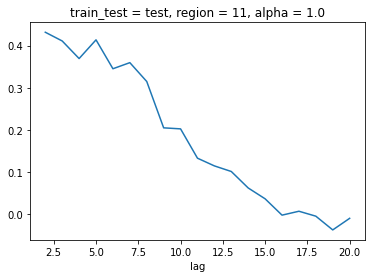

In [74]:
output[1].sel(region=11).sel(train_test='test').sel(alpha=1).plot()

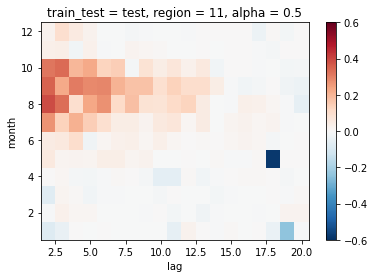

In [86]:
scores_xr.sel(region=11).sel(train_test='test').sel(alpha=0.5).plot(vmin=-0.6, vmax=0.6, cmap='RdBu_r')

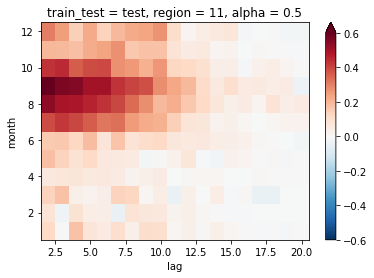

In [83]:
CanESM5_scores.sel(region=11).sel(train_test='test').sel(alpha=0.5).plot(vmin=-0.6, vmax=0.6, cmap='RdBu_r')

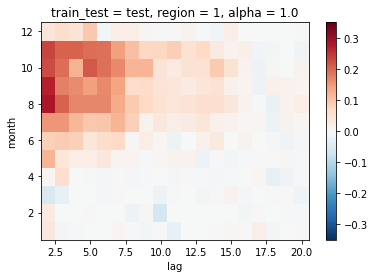

In [70]:
CanESM5_scores.sel(region=1).sel(train_test='test').sel(alpha=1).plot(vmin=-0.35, vmax=0.35, cmap='RdBu_r')